In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

In [3]:
import os
import glob
import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2

from utils.fat_utils import Scene, Side
from utils import coor_utils, visualize, class_names, cv2_utils
from utils import data as datalib

from misc import fragment, uv_map

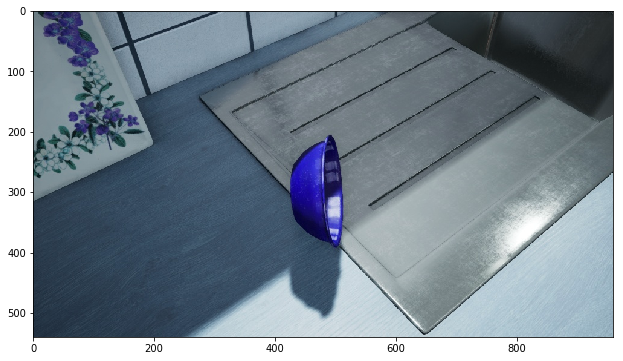

In [6]:
scene = Scene('./fat/single/024_bowl_16k/kitchen_0/', 0)
left = scene.left

img = Image.fromarray(scene.left.img.copy())
plt.imshow(img); plt.show()

model_root = './fat/ycb_models_nvdu_aligned_cm/024_bowl//google_512k/'
pts = datalib.load_obj(model_root+'textured.obj')

# Map on 2D image

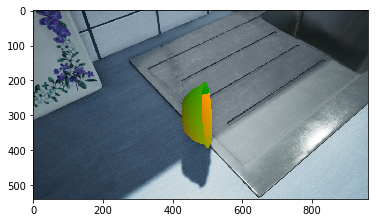

In [5]:
nbins = 256

# Get mapped coordinates
store_dict = dict(depth_sorted_ind=None)
pts_ind = scene.left.transform_point_cloud(pts, ind=0, store_dict=store_dict).astype(int)

pts_disp = pts[store_dict['depth_sorted_ind'], :]

_img = uv_map.draw_uv_map_image(pts_disp, pts_ind, scene.left.img, method='s', bins=nbins)
plt.imshow(_img); plt.show()

## Do PnP fitting

number of valid points:  36318
[[ 0.00466259 -0.0012841  -0.00499667 -0.10845187]
 [ 0.00131594 -0.00028478 -0.00145144 -0.0196784 ]
 [ 0.00087093 -0.0067241   0.00250777  0.14173051]
 [ 0.          0.          0.          0.        ]]
0.269860783634317


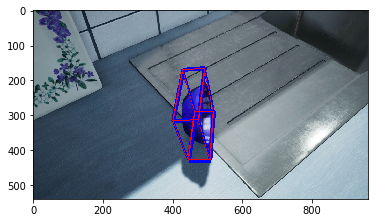

In [6]:
uvm = uv_map.UVMapping(to_256=True, pnp_method='ransac')
uvm.update_backward_cfg_from_side(scene.left)
_ = uvm._compute_map_to_xyz(pts)

# Draw cuboid (qualitative analysis)
img_disp = uvm.fast_estimate_Tmw_and_compare(_img)
plt.imshow(img_disp); plt.show()

## Add noise

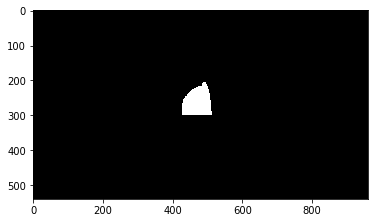

In [7]:
## 1. occlude
# select center and cut mask
segid = 255
mask_y, mask_x, _ = np.where(left.seg == segid)
cen = np.column_stack([mask_y, mask_x]).mean(0).astype(int)
seg_new = left.seg.copy()
seg_new[cen[0]:, :] = 0  # 1/2
# seg_new[:, cen[1]:] = 0  # 1/4
plt.imshow(seg_new)

number of valid points:  17709
[[ 0.00107108 -0.00112481 -0.00590369 -0.11885242]
 [-0.00701012 -0.00128186  0.00784452 -0.0117232 ]
 [-0.00793747 -0.00559476 -0.00587914  0.29949671]
 [ 0.          0.          0.          0.        ]]
0.4300723205736947


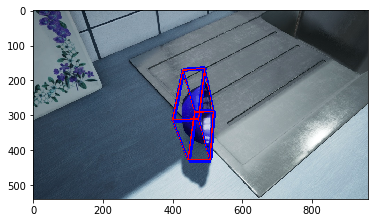

In [8]:
uvm.update_params('mask', seg_new)
plt.imshow(uvm.fast_estimate_Tmw_and_compare(_img));
plt.show()

number of valid points:  17529
[[-3.30221816e-02  6.31387336e-03  1.48362153e-02 -2.15544070e-01]
 [ 4.54445997e-04 -1.47187337e-02  4.47475574e-04 -2.36885119e-01]
 [ 5.79653250e-03  3.31767065e-02 -4.13119770e-03  1.15814517e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
12.033880922571983


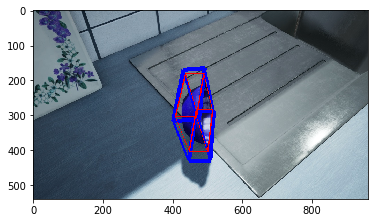

In [9]:
## 2. random select points and mis classify
np.random.seed(0)

rate = 0.02
indexes = [0] + [1 for _ in np.arange(1 // rate)]
keep = np.random.choice(indexes, size=_img.shape)
noise = np.random.randint(0, nbins, size=_img.shape)
img_noise = np.where(keep == 1, _img, noise)

# Draw cuboid (qualitative analysis)
img_disp = uvm.fast_estimate_Tmw_and_compare(img_noise)
plt.imshow(img_disp); plt.show()

number of valid points:  17703
number of valid points:  17592
number of valid points:  17421
number of valid points:  17313
number of valid points:  17232
number of valid points:  17091
number of valid points:  16905
number of valid points:  16842
number of valid points:  16764
number of valid points:  16650
number of valid points:  16443


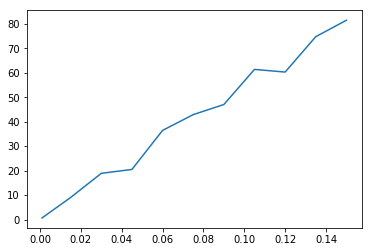

In [10]:
## 2. random select points and mis classify
np.random.seed(0)

rates = [0.001] + [0.015*(1+i) for i in range(10)]

errs = []
for rate in rates:
    indexes = [0] + [1 for _ in np.arange(1 // rate)]
    keep = np.random.choice(indexes, size=_img.shape)
    noise = np.random.randint(0, nbins, size=_img.shape)
    img_noise = np.where(keep == 1, _img, noise)

    # Draw cuboid (qualitative analysis)
    Tmw_est = uvm.fast_estimate_Tmw(img_noise)
    err_norm = np.linalg.norm(left.Tmw_list[0] - Tmw_est, 1)
    errs.append(err_norm)
    

plt.plot(rates, errs, '-')
plt.show()

# UV Map extended With fragments

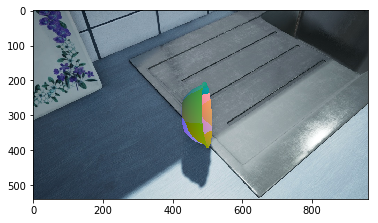

In [52]:
nbins = 256
frag_bins = 8

# Get mapped coordinates
store_dict = dict(depth_sorted_ind=None)
pts_ind = scene.left.transform_point_cloud(pts, ind=0, store_dict=store_dict).astype(int)

pts_disp = pts[store_dict['depth_sorted_ind'], :]

_img = uv_map.draw_uvf_map_image(
    pts_disp, pts_ind, scene.left.img, method='s', 
    uv_bins=nbins, frag_bins=frag_bins)
plt.imshow(_img); plt.show()

number of valid points:  36318
[[ 0.00459167 -0.00125217 -0.0048465  -0.10711483]
 [ 0.00128591 -0.00022771 -0.00142207 -0.02014353]
 [ 0.00084611 -0.00656762  0.0024461   0.12531328]
 [ 0.          0.          0.          0.        ]]
0.2525716444842776


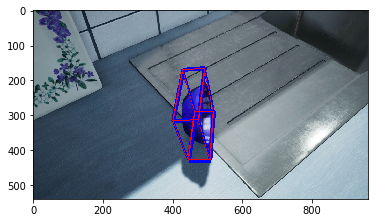

In [53]:
uvf = uv_map.UVFragMapping(
    to_256=True,
    uv_bins=nbins, frag_bins=frag_bins, pnp_method='ransac')
uvf.update_backward_cfg_from_side(left)
_ = uvf._compute_map_to_xyz(pts)

img_disp = uvf.fast_estimate_Tmw_and_compare(_img)
plt.imshow(img_disp); plt.show()

number of valid points:  16848
[[ 2.03078649e-04 -9.62707343e-04 -5.41329486e-03 -1.10358235e-01]
 [-6.81482486e-03 -1.63866568e-03  7.65687426e-03 -1.93651117e-02]
 [-7.60808574e-03 -4.63203701e-03 -5.81804641e-03  5.22728552e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0.6524518988284054


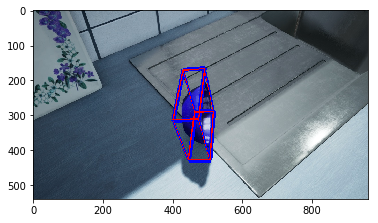

In [54]:
## 1. occlude
# select center and cut mask
segid = 255
mask_y, mask_x, _ = np.where(left.seg == segid)
cen = np.column_stack([mask_y, mask_x]).mean(0).astype(int)
seg_new = left.seg.copy()
seg_new[cen[0]:, :] = 0  # 1/2
# seg_new[:, cen[1]:] = 0  # 1/4
uvf.update_params('mask', seg_new)

## 2. random select points and mis classify
np.random.seed(0)

rate = 0.02
indexes = [0] + [1 for _ in np.arange(1 // rate)]
keep = np.random.choice(indexes, size=_img.shape)
noise = np.random.randint(0, uvf.uv_bins, size=_img.shape)
noise[:, :, -1] = np.random.randint(0, uvf.frag_bins, size=_img.shape[:2])
img_noise = np.where(keep == 1, _img, noise)

# Draw cuboid (qualitative analysis)
img_disp = uvf.fast_estimate_Tmw_and_compare(img_noise)
plt.imshow(img_disp); plt.show()

number of valid points:  17673
number of valid points:  17103
number of valid points:  16503
number of valid points:  15837
number of valid points:  15162
number of valid points:  14712
number of valid points:  14367
number of valid points:  13440
number of valid points:  13212
number of valid points:  12834
number of valid points:  11994


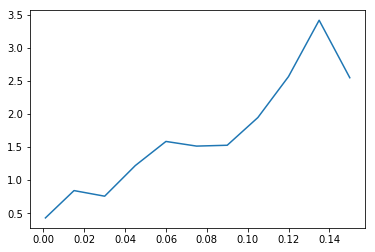

In [55]:
## 2. random select points and mis classify
np.random.seed(0)

rates = [0.001] + [0.015*(1+i) for i in range(10)]

errs = []
for rate in rates:
    indexes = [0] + [1 for _ in np.arange(1 // rate)]
    keep = np.random.choice(indexes, size=_img.shape)
    noise = np.random.randint(0, uvf.uv_bins, size=_img.shape)
    noise[:, :, -1] = np.random.randint(0, uvf.frag_bins, size=_img.shape[:2])
    img_noise = np.where(keep == 1, _img, noise)

    # Draw cuboid (qualitative analysis)
    Tmw_est = uvf.fast_estimate_Tmw(img_noise)
    err_norm = np.linalg.norm(left.Tmw_list[0] - Tmw_est, 1)
    errs.append(err_norm)
    

plt.plot(rates, errs, '-')
plt.show()

# Random: SHOULD WRITE A PYTHON SCRIPT

In [13]:
nbins = 16

single_root = './fat/single/'
mod = np.random.choice(glob.glob(os.path.join(single_root, '*')))
place = np.random.choice(glob.glob(os.path.join(mod, '*')))
num_scenes = len(glob.glob(os.path.join(place, '*.left.jpg')))
index = np.random.choice(num_scenes)

Model Name:  052_extra_large_clamp


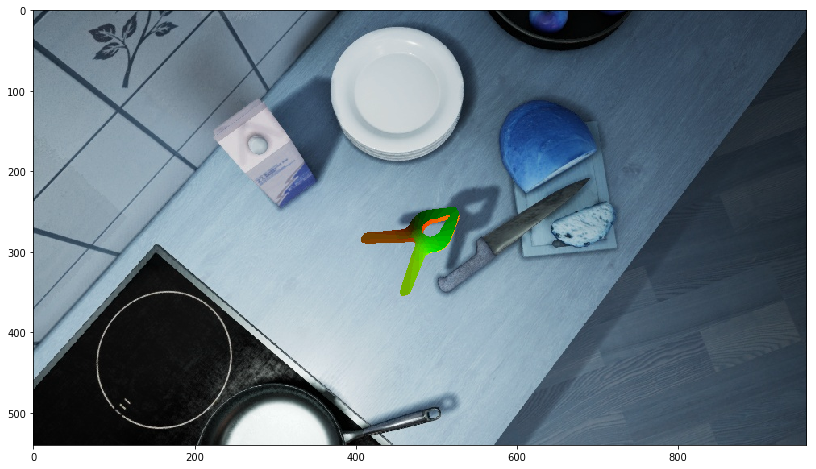

In [14]:
scene = Scene(place, index)
model_name = scene.left.objects[0]['class'].replace('_16k', '').replace('_16K', '')
# model_name = place.split('/')[-2].replace('_16k', '').replace('_16K', '')
model_root = f"./fat/ycb_models_nvdu_aligned_cm/{model_name}/google_512k/"
pts = datalib.load_obj(model_root+'textured.obj')

img = Image.fromarray(scene.left.img.copy())

# Get mapped coordinates
store_dict = dict(depth_sorted_ind=None)
pts_ind = scene.left.transform_point_cloud(pts, ind=0, store_dict=store_dict).astype(int)

_img = uv_map.draw_uv_map_image(
    pts[store_dict['depth_sorted_ind']], pts_ind, scene.left.img, method='s', bins=nbins)
print("Model Name: ", model_name)
plt.imshow(_img);
plt.show()